# Image Classification with CNNs

In this tutorial, we'll build a complete image classification system using Convolutional Neural Networks (CNNs) in BrainState.

## Learning Objectives

By the end of this tutorial, you will be able to:
- Build CNN architectures for image classification
- Load and preprocess image datasets (MNIST-like)
- Implement complete training loops
- Evaluate model performance
- Visualize results and predictions
- Apply data augmentation
- Monitor training progress

## What We'll Build

We'll create:
- A CNN architecture from scratch
- A training pipeline with validation
- Evaluation metrics and visualization
- A complete end-to-end workflow

In [58]:
import brainstate
import braintools
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import time

# Set random seed for reproducibility
brainstate.random.seed(42)

print(f"JAX devices: {jax.devices()}")

JAX devices: [CpuDevice(id=0)]


## 1. Dataset Preparation

We'll create synthetic MNIST-like data for demonstration.

In [71]:
def generate_synthetic_mnist(n_samples: int = 1000, img_size: int = 28, n_classes: int = 10):
    """Generate synthetic MNIST-like dataset.
    
    Args:
        n_samples: Number of samples to generate
        img_size: Image size (height and width)
        n_classes: Number of classes
        
    Returns:
        images: Array of shape (n_samples, img_size, img_size, 1)
        labels: Array of shape (n_samples,)
    """
    # Generate random images with patterns
    images = brainstate.random.randn(n_samples, img_size, img_size, 1) * 0.4
    labels = brainstate.random.randint(0, n_classes, (n_samples,))
    
    # Add class-specific patterns
    for i in range(n_samples):
        label = int(labels[i])
        
        
        if label == 0:  # circle
            center_x, center_y = img_size//2, img_size//2
            radius = 8
            for x in range(img_size):
                for y in range(img_size):
                    dist = (x-center_x)**2 + (y-center_y)**2
                    if radius**2 - 3 <= dist <= radius**2 + 3:
                        images = images.at[i, x, y, 0].set(0.9)
        
        elif label == 1:  # Vertical line + bottom small horizontal line (similar to 7)
            center = img_size//2
            images = images.at[i, center-1:center+1, 5:img_size-5, 0].set(0.9)
            images = images.at[i, img_size-6:img_size-4, center-3:center+3, 0].set(0.9)
        
        elif label == 2:  
            images = images.at[i, 5, 5:img_size-5, 0].set(0.9)
            images = images.at[i, 6, 5:img_size-5, 0].set(0.9)
            for j in range(10):
                images = images.at[i, 6+j, img_size-6-j, 0].set(0.9)
                images = images.at[i, 7+j, img_size-6-j, 0].set(0.9)
            images = images.at[i, img_size-6, 5:img_size-5, 0].set(0.9)
            images = images.at[i, img_size-7, 5:img_size-5, 0].set(0.9)
        
        elif label == 3:   
            images = images.at[i, 5, img_size-10:img_size-5, 0].set(0.9)
            images = images.at[i, img_size//2, img_size-10:img_size-5, 0].set(0.9)
            images = images.at[i, img_size-6, img_size-10:img_size-5, 0].set(0.9)
            images = images.at[i, 5:img_size-5, img_size-6, 0].set(0.9)
        
        elif label == 4:  
            images = images.at[i, 5:img_size//2+3, 6, 0].set(0.9)
            images = images.at[i, img_size//2, 5:img_size-5, 0].set(0.9)
            images = images.at[i, 5:img_size-5, img_size-6, 0].set(0.9)
        
        elif label == 5: 
            images = images.at[i, 5, 5:img_size-5, 0].set(0.9)
            images = images.at[i, 5:img_size//2+1, 6, 0].set(0.9)
            images = images.at[i, img_size//2, 5:img_size-5, 0].set(0.9)
            images = images.at[i, img_size//2:img_size-5, img_size-6, 0].set(0.9)
            images = images.at[i, img_size-6, 5:img_size-5, 0].set(0.9)
        
        elif label == 6: 
            center_x, center_y = img_size//2+3, img_size//2+3
            radius = 7
            for x in range(img_size):
                for y in range(img_size):
                    dist = (x-center_x)**2 + (y-center_y)**2
                    if radius**2 - 3 <= dist <= radius**2 + 3 and x >= center_x-2:
                        images = images.at[i, x, y, 0].set(0.9)
            images = images.at[i, 5:img_size-5, 6, 0].set(0.9)
        
        elif label == 7: 
            images = images.at[i, 5, 5:img_size-5, 0].set(0.9)
            for j in range(15):
                images = images.at[i, 6+j, img_size-6-j, 0].set(0.9)
        
        elif label == 8: 
            center_x1, center_y1 = img_size//3+1, img_size//2
            radius1 = 4
            for x in range(img_size):
                for y in range(img_size):
                    dist = (x-center_x1)**2 + (y-center_y1)**2
                    if radius1**2 - 2 <= dist <= radius1**2 + 2:
                        images = images.at[i, x, y, 0].set(0.9)
            
            center_x2, center_y2 = 2*img_size//3-1, img_size//2
            radius2 = 4
            for x in range(img_size):
                for y in range(img_size):
                    dist = (x-center_x2)**2 + (y-center_y2)**2
                    if radius2**2 - 2 <= dist <= radius2**2 + 2:
                        images = images.at[i, x, y, 0].set(0.9)
        
        elif label == 9:
            center_x, center_y = img_size//2-3, img_size//2-3
            radius = 7
            for x in range(img_size):
                for y in range(img_size):
                    dist = (x-center_x)**2 + (y-center_y)**2
                    if radius**2 - 3 <= dist <= radius**2 + 3 and x <= center_x+2:
                        images = images.at[i, x, y, 0].set(0.9)
            images = images.at[i, 5:img_size-5, img_size-6, 0].set(0.9)  
    
    # Normalize to [0, 1]
    images = (images - images.min()) / (images.max() - images.min())
    
    return images, labels

# Generate datasets
print("Generating synthetic dataset...")
X_train, y_train = generate_synthetic_mnist(n_samples=5000)
X_val, y_val = generate_synthetic_mnist(n_samples=500)
X_test, y_test = generate_synthetic_mnist(n_samples=1000)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Generating synthetic dataset...
Training set: (5000, 28, 28, 1), (5000,)
Validation set: (500, 28, 28, 1), (500,)
Test set: (1000, 28, 28, 1), (1000,)


### Visualize Dataset

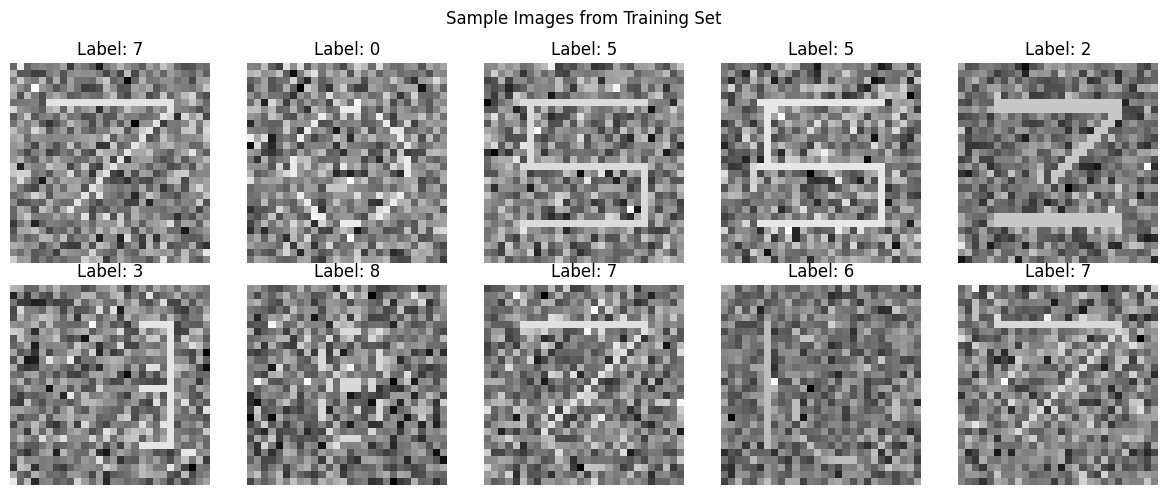

In [72]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(X_train[i, :, :, 0], cmap='gray')
    axes[i].set_title(f'Label: {y_train[i]}')
    axes[i].axis('off')

plt.suptitle('Sample Images from Training Set')
plt.tight_layout()
plt.show()

## 2. Build CNN Architecture

In [61]:

class ConvBlock(brainstate.nn.Module):
    """Convolutional block with Conv -> BatchNorm -> ReLU -> MaxPool."""

    def __init__(self, in_size, out_channels, kernel_size=3, pool_size=2):
        super().__init__()
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if isinstance(pool_size, int):
            pool_size = (pool_size, pool_size)

        self.conv = brainstate.nn.Conv2d(
            in_size=in_size,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding='SAME'
        )
        self.bn = brainstate.nn.BatchNorm2d(in_size=self.conv.out_size)
        self.activation = brainstate.nn.ReLU()
        self.pool = brainstate.nn.MaxPool2d(
            kernel_size=pool_size,
            stride=pool_size,
            channel_axis=-1,
            in_size=self.conv.out_size
        )

        self.in_size = self.conv.in_size
        self.out_size = self.pool.out_size

    def update(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        x = self.pool(x)
        return x


class ImageClassifier(brainstate.nn.Module):
    """CNN for image classification."""

    def __init__(self, input_shape=(28, 28, 1), num_classes=10, dropout_prob=0.5):
        super().__init__()
        self.conv1 = ConvBlock(in_size=input_shape, out_channels=32, kernel_size=3)
        self.conv2 = ConvBlock(in_size=self.conv1.out_size, out_channels=64, kernel_size=3)

        self.flatten = brainstate.nn.Flatten(in_size=self.conv2.out_size)
        self.fc1 = brainstate.nn.Linear(in_size=self.flatten.out_size, out_size=(128,))
        self.activation = brainstate.nn.ReLU()
        self.dropout = brainstate.nn.Dropout(prob=dropout_prob)
        self.fc2 = brainstate.nn.Linear(in_size=self.fc1.out_size, out_size=(num_classes,))

        self.in_size = self.conv1.in_size
        self.out_size = (num_classes,)

    def update(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create model
model = ImageClassifier(num_classes=10)

# Test forward pass
test_batch = X_train[:4]
with brainstate.environ.context(fit=True):
    test_output = model(test_batch)

print(f"Input shape: {test_batch.shape}")
print(f"Output shape: {test_output.shape}")

brainstate.nn.count_parameters(model)


Input shape: (4, 28, 28, 1)
Output shape: (4, 10)
+-----------------------------+------------+
|           Modules           | Parameters |
+-----------------------------+------------+
|  ('conv1', 'bn', 'weight')  |     64     |
| ('conv1', 'conv', 'weight') |    288     |
|  ('conv2', 'bn', 'weight')  |    128     |
| ('conv2', 'conv', 'weight') |   18.43K   |
|      ('fc1', 'weight')      |  401.54K   |
|      ('fc2', 'weight')      |   1.29K    |
|            Total            |  421.74K   |
+-----------------------------+------------+


421738

## 3. Training Setup

In [62]:
def cross_entropy_loss(logits, labels):
    """Compute cross-entropy loss.
    
    Args:
        logits: Model outputs of shape (batch_size, num_classes)
        labels: True labels of shape (batch_size,)
        
    Returns:
        Scalar loss value
    """
    # Convert labels to one-hot
    num_classes = logits.shape[-1]
    one_hot_labels = jax.nn.one_hot(labels, num_classes)
    
    # Compute log softmax
    log_probs = jax.nn.log_softmax(logits, axis=-1)
    
    # Compute loss
    loss = -jnp.mean(jnp.sum(one_hot_labels * log_probs, axis=-1))
    
    return loss

def accuracy(logits, labels):
    """Compute classification accuracy.
    
    Args:
        logits: Model outputs of shape (batch_size, num_classes)
        labels: True labels of shape (batch_size,)
        
    Returns:
        Accuracy as a float
    """
    predictions = jnp.argmax(logits, axis=-1)
    return jnp.mean(predictions == labels)

# Test loss and accuracy
test_loss = cross_entropy_loss(test_output, y_train[:4])
test_acc = accuracy(test_output, y_train[:4])

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 5.3273
Test accuracy: 0.0000


### Training Step

In [63]:

def make_train_step(model, optimizer):
    """Create a training step function for the model."""

    @brainstate.transform.jit
    def train_step(x_batch, y_batch):
        """Perform one training step.

        Args:
            x_batch: Input batch
            y_batch: Label batch

        Returns:
            Dictionary with loss and accuracy
        """
        with brainstate.environ.context(fit=True):
            # Define loss function
            def loss_fn():
                logits = model(x_batch)
                return cross_entropy_loss(logits, y_batch)

            # Compute loss and gradients
            grads, loss = brainstate.transform.grad(
                loss_fn,
                model.states(brainstate.ParamState),
                return_value=True
            )()

            # Update parameters using optimizer
            optimizer.update(grads)

            # Compute accuracy
            logits = model(x_batch)
            acc = accuracy(logits, y_batch)

            return loss, acc

    return train_step

def make_eval_step(model):
    """Create an evaluation step function for the model."""

    @brainstate.transform.jit
    def eval_step(x_batch, y_batch):
        """Perform one evaluation step.

        Args:
            x_batch: Input batch
            y_batch: Label batch

        Returns:
            Dictionary with loss and accuracy
        """
        with brainstate.environ.context(fit=False):
            logits = model(x_batch)
            loss = cross_entropy_loss(logits, y_batch)
            acc = accuracy(logits, y_batch)

            return loss, acc

    return eval_step

# Test training step
batch_size = 32
x_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Create optimizer
optimizer = braintools.optim.Adam(lr=0.001)
optimizer.register_trainable_weights(model.states(brainstate.ParamState))
train_step = make_train_step(model, optimizer)
loss, acc = train_step(x_batch, y_batch)
print(f"Training step metrics: loss={loss:.4f}, accuracy={acc:.4f}")


Training step metrics: loss=3.5152, accuracy=0.2812


## 4. Complete Training Loop

In [64]:
def create_batches(X, y, batch_size, shuffle=True):
    """Create batches from dataset.
    
    Args:
        X: Input data
        y: Labels
        batch_size: Batch size
        shuffle: Whether to shuffle data
        
    Yields:
        Tuples of (x_batch, y_batch)
    """
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

def train_epoch(train_step, X_train, y_train, batch_size):
    """Train for one epoch.

    Returns:
        Dictionary with average metrics
    """
    losses = []
    accuracies = []

    for x_batch, y_batch in create_batches(X_train, y_train, batch_size, shuffle=True):
        loss, acc = train_step(x_batch, y_batch)
        losses.append(float(loss))
        accuracies.append(float(acc))

    return {
        'loss': np.mean(losses),
        'accuracy': np.mean(accuracies)
    }

def evaluate(eval_step, X, y, batch_size):
    """Evaluate model on dataset.

    Returns:
        Dictionary with average metrics
    """
    losses = []
    accuracies = []

    for x_batch, y_batch in create_batches(X, y, batch_size, shuffle=False):
        loss, acc = eval_step(x_batch, y_batch)
        losses.append(float(loss))
        accuracies.append(float(acc))

    return {
        'loss': np.mean(losses),
        'accuracy': np.mean(accuracies)
    }

# Training configuration
config = {
    'num_epochs': 20,
    'batch_size': 64,
    'learning_rate': 0.001,
}

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}

# Recreate model for fresh training
model = ImageClassifier(num_classes=10)

# Create optimizer
optimizer = braintools.optim.Adam(lr=config['learning_rate'])
optimizer.register_trainable_weights(model.states(brainstate.ParamState))

# Create train and eval step functions
train_step = make_train_step(model, optimizer)
eval_step = make_eval_step(model)

print("Starting training...")
print("=" * 70)

best_val_acc = 0.0
start_time = time.time()

for epoch in range(config['num_epochs']):
    # Train
    train_metrics = train_epoch(
        train_step, X_train, y_train,
        config['batch_size']
    )

    # Validate
    val_metrics = evaluate(eval_step, X_val, y_val, config['batch_size'])
    
    # Record history
    history['train_loss'].append(train_metrics['loss'])
    history['train_acc'].append(train_metrics['accuracy'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    
    # Track best model
    if val_metrics['accuracy'] > best_val_acc:
        best_val_acc = val_metrics['accuracy']
        best_epoch = epoch
    
    # Print progress
    if epoch % 5 == 0 or epoch == config['num_epochs'] - 1:
        print(f"Epoch {epoch:2d}/{config['num_epochs']}: "
              f"train_loss={train_metrics['loss']:.4f}, "
              f"train_acc={train_metrics['accuracy']:.4f}, "
              f"val_loss={val_metrics['loss']:.4f}, "
              f"val_acc={val_metrics['accuracy']:.4f}")

training_time = time.time() - start_time
print("=" * 70)
print(f"Training completed in {training_time:.2f}s")
print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

Starting training...
Epoch  0/20: train_loss=2.0550, train_acc=0.3200, val_loss=2.2914, val_acc=0.1121
Epoch  5/20: train_loss=0.4747, train_acc=0.7969, val_loss=0.0065, val_acc=1.0000
Epoch 10/20: train_loss=0.4055, train_acc=0.8105, val_loss=0.0008, val_acc=1.0000
Epoch 15/20: train_loss=0.3754, train_acc=0.8068, val_loss=0.0009, val_acc=1.0000
Epoch 19/20: train_loss=0.3752, train_acc=0.8129, val_loss=0.0002, val_acc=1.0000
Training completed in 70.75s
Best validation accuracy: 1.0000 at epoch 3


## 5. Visualize Training Progress

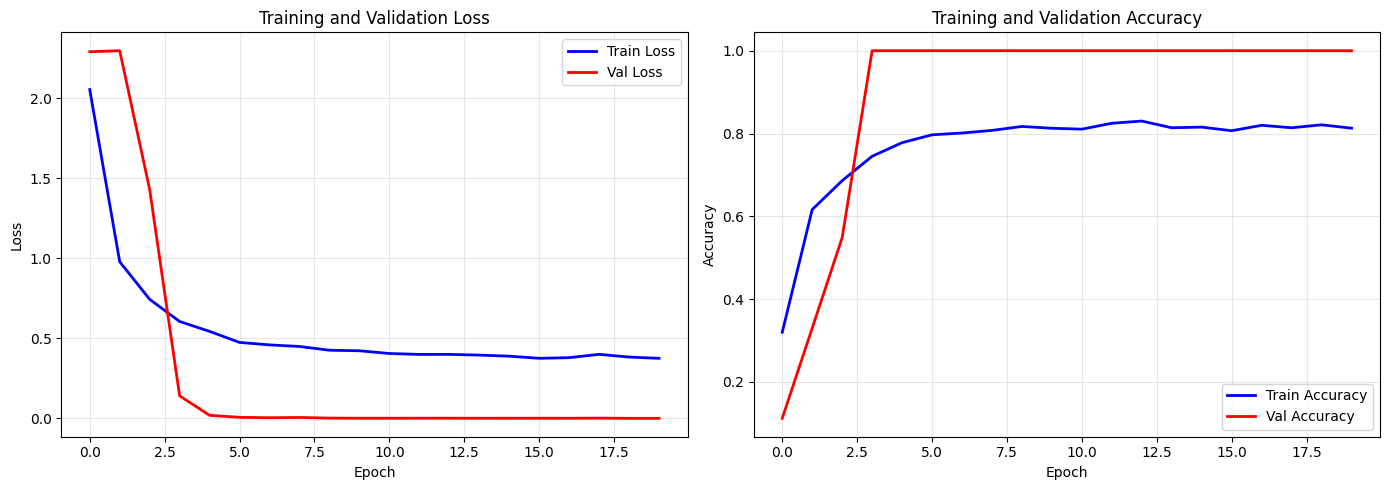

In [65]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
epochs = range(len(history['train_loss']))
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Model Evaluation

In [66]:
# Evaluate on test set
test_metrics = evaluate(eval_step, X_test, y_test, batch_size=64)

print("Test Set Performance:")
print("=" * 50)
print(f"Loss: {test_metrics['loss']:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Error Rate: {(1 - test_metrics['accuracy']) * 100:.2f}%")

Test Set Performance:
Loss: 0.0005
Accuracy: 1.0000
Error Rate: 0.00%


### Confusion Matrix

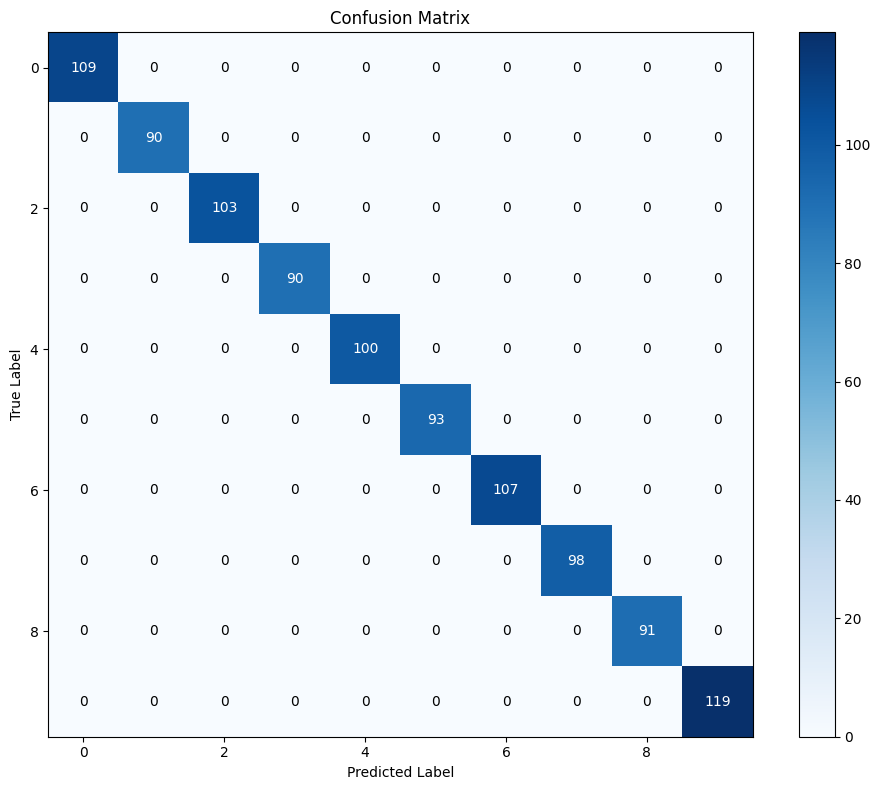


Per-Class Accuracy:
Class 0: 1.0000 (109/109)
Class 1: 1.0000 (90/90)
Class 2: 1.0000 (103/103)
Class 3: 1.0000 (90/90)
Class 4: 1.0000 (100/100)
Class 5: 1.0000 (93/93)
Class 6: 1.0000 (107/107)
Class 7: 1.0000 (98/98)
Class 8: 1.0000 (91/91)
Class 9: 1.0000 (119/119)


In [67]:
def compute_confusion_matrix(model, X, y, num_classes=10, batch_size=64):
    """Compute confusion matrix.
    
    Returns:
        Confusion matrix of shape (num_classes, num_classes)
    """
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    with brainstate.environ.context(fit=False):
        for x_batch, y_batch in create_batches(X, y, batch_size, shuffle=False):
            logits = model(x_batch)
            predictions = jnp.argmax(logits, axis=-1)
            
            for true_label, pred_label in zip(y_batch, predictions):
                confusion_matrix[int(true_label), int(pred_label)] += 1
    
    return confusion_matrix

# Compute confusion matrix
cm = compute_confusion_matrix(model, X_test, y_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(cm[i, j]), 
                ha='center', va='center',
                color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
print("=" * 50)
for i in range(10):
    class_total = cm[i].sum()
    class_correct = cm[i, i]
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"Class {i}: {class_acc:.4f} ({class_correct}/{class_total})")

## 7. Visualize Predictions

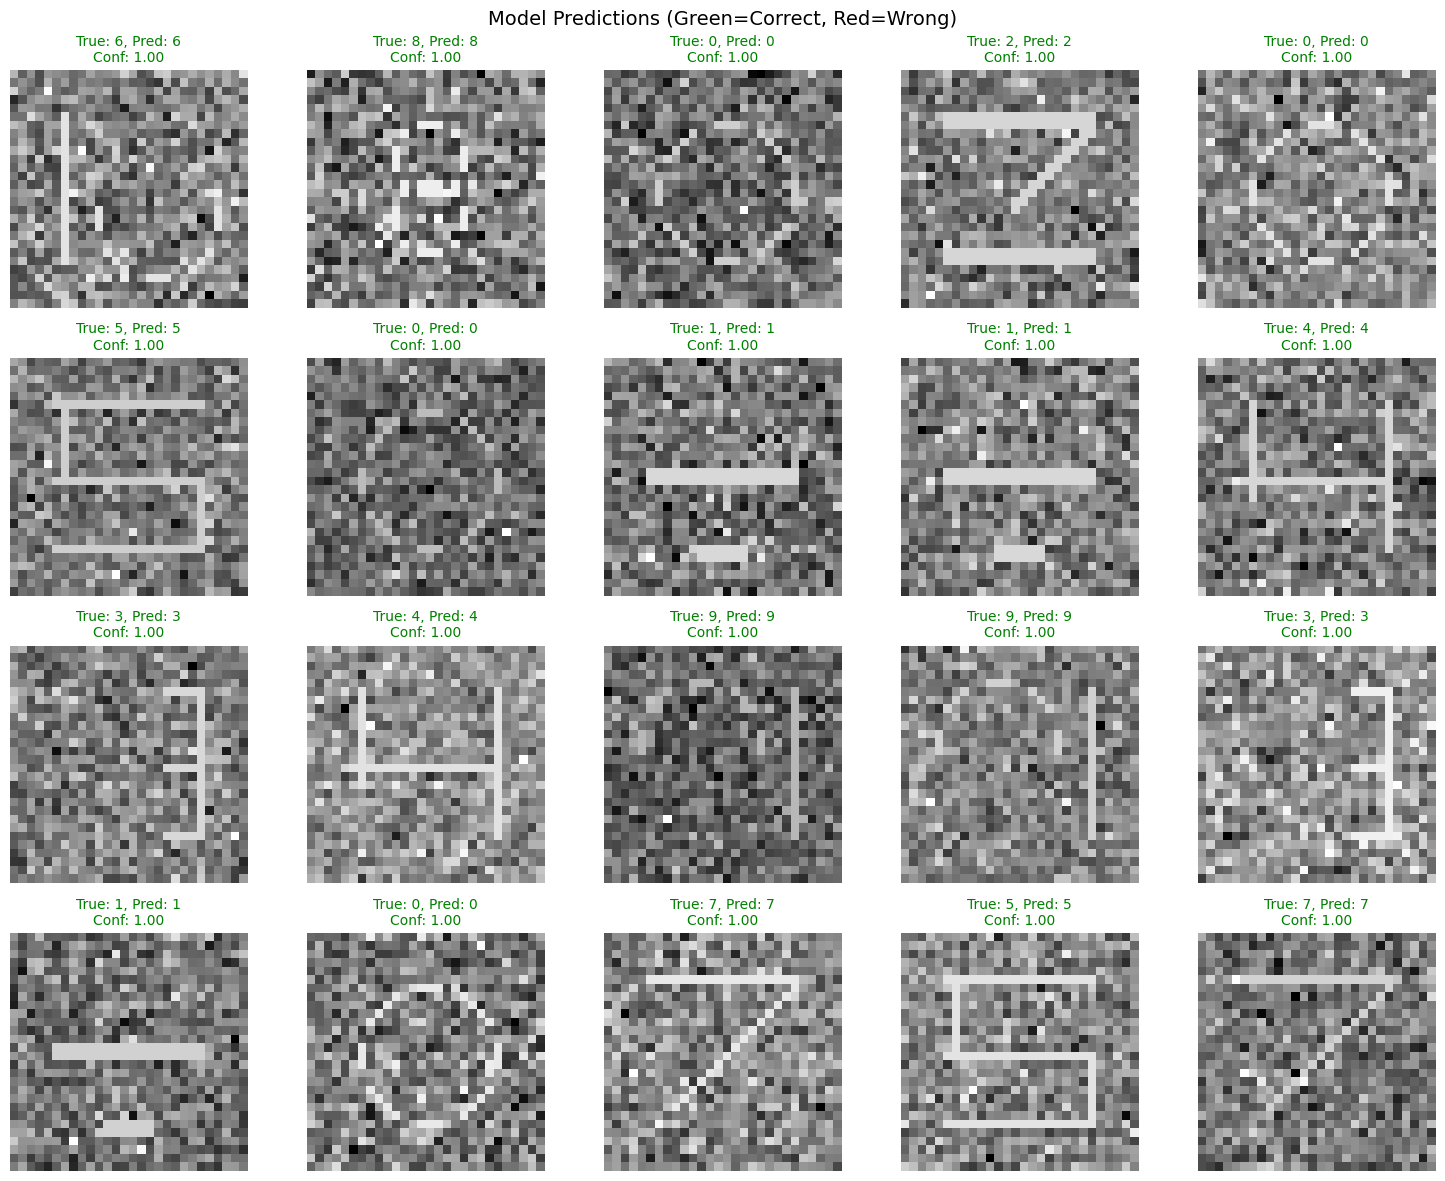

In [68]:
# Get predictions for test samples
n_samples = 20
test_samples = X_test[:n_samples]
test_labels = y_test[:n_samples]

with brainstate.environ.context(fit=False):
    logits = model(test_samples)
    predictions = jnp.argmax(logits, axis=-1)
    probabilities = jax.nn.softmax(logits, axis=-1)

# Visualize predictions
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(n_samples):
    ax = axes[i]
    
    # Show image
    ax.imshow(test_samples[i, :, :, 0], cmap='gray')
    
    # Title with prediction
    true_label = int(test_labels[i])
    pred_label = int(predictions[i])
    confidence = float(probabilities[i, pred_label])
    
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(
        f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}',
        color=color,
        fontsize=10
    )
    ax.axis('off')

plt.suptitle('Model Predictions (Green=Correct, Red=Wrong)', fontsize=14)
plt.tight_layout()
plt.show()

### Prediction Confidence Distribution

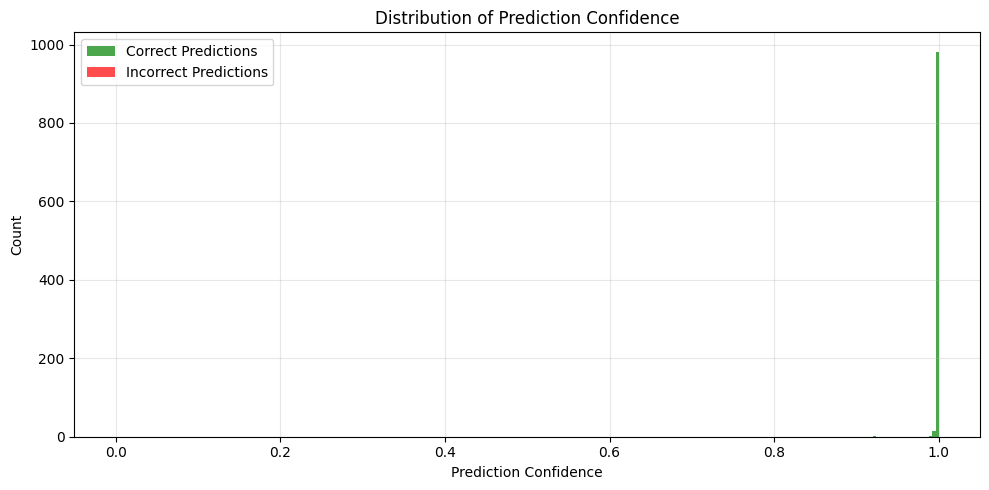

Average confidence for correct predictions: 0.9995
Average confidence for incorrect predictions: nan


In [69]:
# Analyze prediction confidence
with brainstate.environ.context(fit=False):
    all_logits = model(X_test)
    all_predictions = jnp.argmax(all_logits, axis=-1)
    all_probs = jax.nn.softmax(all_logits, axis=-1)

# Get max probability for each prediction
max_probs = jnp.max(all_probs, axis=-1)

# Separate correct and incorrect predictions
correct_mask = (all_predictions == y_test)
correct_probs = max_probs[correct_mask]
incorrect_probs = max_probs[~correct_mask]

# Plot confidence distributions
plt.figure(figsize=(10, 5))

plt.hist(correct_probs, bins=20, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(incorrect_probs, bins=20, alpha=0.7, label='Incorrect Predictions', color='red')

plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Distribution of Prediction Confidence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average confidence for correct predictions: {jnp.mean(correct_probs):.4f}")
print(f"Average confidence for incorrect predictions: {jnp.mean(incorrect_probs):.4f}")

## 8. Feature Visualization

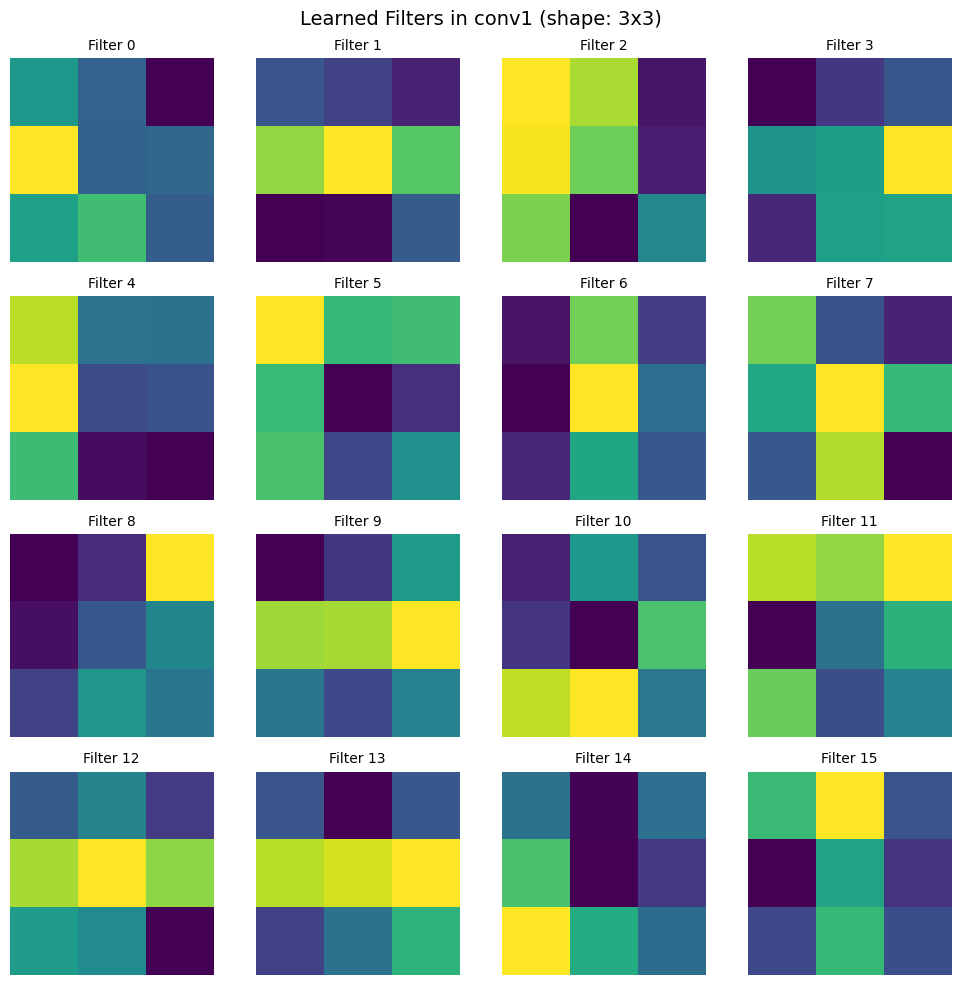

Visualized 16 filters from conv1 (filter shape: 3x3x1)


In [75]:
# # Visualize learned filters
# def visualize_conv_filters(model, layer_name='conv1'):
#     """Visualize convolutional filters."""
#     # Get first conv layer
#     conv_layer = getattr(model, layer_name)

#     # Get weight - it might be a dict or direct value
#     weight = conv_layer.conv.weight
#     if isinstance(weight.value, dict):
#         # If it's a dict, get the first value
#         filters = list(weight.value.values())[0]
#     else:
#         filters = weight.value  # Shape: (out_ch, in_ch, kh, kw)

#     n_filters = min(16, filters.shape[0])
    
#     fig, axes = plt.subplots(4, 4, figsize=(10, 10))
#     axes = axes.flatten()
    
#     for i in range(n_filters):
#         # Get filter for first input channel
#         filter_img = filters[i, 0, :, :]
        
#         axes[i].imshow(filter_img, cmap='gray')
#         axes[i].set_title(f'Filter {i}')
#         axes[i].axis('off')
    
#     plt.suptitle(f'Learned Filters in {layer_name}')
#     plt.tight_layout()
#     plt.show() 

# visualize_conv_filters(model, 'conv1')



# Visualize learned filters
def visualize_conv_filters(model, layer_name='conv1'):
    """Visualize convolutional filters.

    Args:
        model: The neural network model
        layer_name: Name of the convolutional block to visualize (e.g., 'conv1', 'conv2')
    """
    # Get the conv layer
    conv_layer = getattr(model, layer_name)

    # Get weight - brainstate stores it in a dict
    weight = conv_layer.conv.weight
    if isinstance(weight.value, dict):
        # Extract the actual weight tensor from dict
        filters = list(weight.value.values())[0] 
    else:
        filters = weight.value

    # BrainState Conv2d uses shape: (kernel_height, kernel_width, in_channels, out_channels)
    # This is different from PyTorch which uses (out_channels, in_channels, kh, kw)
    kh, kw, in_ch, out_ch = filters.shape

    # Visualize up to 16 filters
    n_filters = min(16, out_ch)

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(n_filters):
        # Get the i-th output filter from the first input channel
        # Shape is (kh, kw, in_ch, out_ch), so we need [:, :, 0, i]
        filter_img = filters[:, :, 0, i]

        axes[i].imshow(filter_img, cmap='viridis', interpolation='nearest')
        axes[i].set_title(f'Filter {i}', fontsize=10)
        axes[i].axis('off')

    # Hide any unused subplots
    for i in range(n_filters, 16):
        axes[i].axis('off')

    plt.suptitle(f'Learned Filters in {layer_name} (shape: {kh}x{kw})', fontsize=14)
    plt.tight_layout()
    # plt.savefig(f'{layer_name}_filters.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Visualized {n_filters} filters from {layer_name} (filter shape: {kh}x{kw}x{in_ch})")

visualize_conv_filters(model, 'conv1')

